In [66]:
from IPython import get_ipython
from IPython.display import display

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Input
from scikeras.wrappers import KerasClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import classification_report, confusion_matrix
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import accuracy_score

In [61]:
data = pd.read_csv('/content/Bank_customer_data.csv')

data.head(3)

,ID,Age,Experience,Income,Zipcode,Family,CCAvg,Education,Mortgage,Securities Account,CD Account,Online,CreditCard,Personal Loan
0,1,39,14,127000,49560,1,567.28,2,36000,1,0,1,0,1
1,2,36,0,72000,63865,1,3927.17,1,341000,1,0,0,0,0
2,3,37,5,147000,56686,2,369.79,1,326000,0,0,0,1,0


In [62]:
# Check if columns exist before dropping
if 'ID' in data.columns and 'Zipcode' in data.columns:
    data.drop(['ID', 'Zipcode'], axis=1, inplace=True)
else:
    print("Columns 'ID' and/or 'Zipcode' have already been removed.")

# Split into features and target
X = data.drop("Personal Loan", axis=1)
y = data["Personal Loan"]

# Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

# Handle class imbalance
sm = SMOTE(random_state=42)
X_train_res, y_train_res = sm.fit_resample(X_train, y_train)

# Scale features
scaler = StandardScaler()
X_train_res = scaler.fit_transform(X_train_res)
X_test = scaler.transform(X_test)

In [68]:
# 6. Build the model
model = Sequential([
    Input(shape=(X_train.shape[1],)),
    Dense(32, activation='relu'),
    Dropout(0.3),
    Dense(16, activation='relu'),
    Dense(1, activation='sigmoid')
])
# 7. Compile the model
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

# 8. Train the model
history = model.fit(X_train, y_train, epochs=50, batch_size=32, validation_split=0.2, verbose=1)

# 9. Evaluate on test data
y_pred_prob = model.predict(X_test)
y_pred = (y_pred_prob > 0.5).astype(int)

print("\nAccuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred))

Epoch 1/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step - accuracy: 0.2364 - loss: 20151.8164 - val_accuracy: 0.4250 - val_loss: 8748.4434
Epoch 2/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.4361 - loss: 9952.5537 - val_accuracy: 0.6750 - val_loss: 1438.1226
Epoch 3/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.6246 - loss: 4744.3530 - val_accuracy: 0.8250 - val_loss: 1992.3975
Epoch 4/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.7235 - loss: 3395.9136 - val_accuracy: 0.8250 - val_loss: 2669.2805
Epoch 5/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.7663 - loss: 3426.6665 - val_accuracy: 0.8250 - val_loss: 2807.6648
Epoch 6/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.7956 - loss: 2945.1221 - val_accuracy: 0.8250 - val_loss: 2464.5286
Epoch 7/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.7812 - loss: 2578.9446 - val_accuracy: 0.8250 - val_loss: 2018.8369
Epoch 8/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.7547

In [69]:

# Create a DataFrame with actual vs predicted labels
df_test_results = pd.DataFrame({"Actual": y_test, "Predicted": y_pred.flatten()})

# Find misclassified cases
misclassified = df_test_results[df_test_results["Actual"] != df_test_results["Predicted"]]
print("Misclassified Samples:\n", misclassified.head())


Misclassified Samples:
      Actual  Predicted
365       0          1
38        0          1
199       0          1
364       0          1
147       1          0


PermutationExplainer explainer: 101it [00:17,  2.96it/s]
<ipython-input-79-ad626b63c991>:8: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(shap_values, X_test)


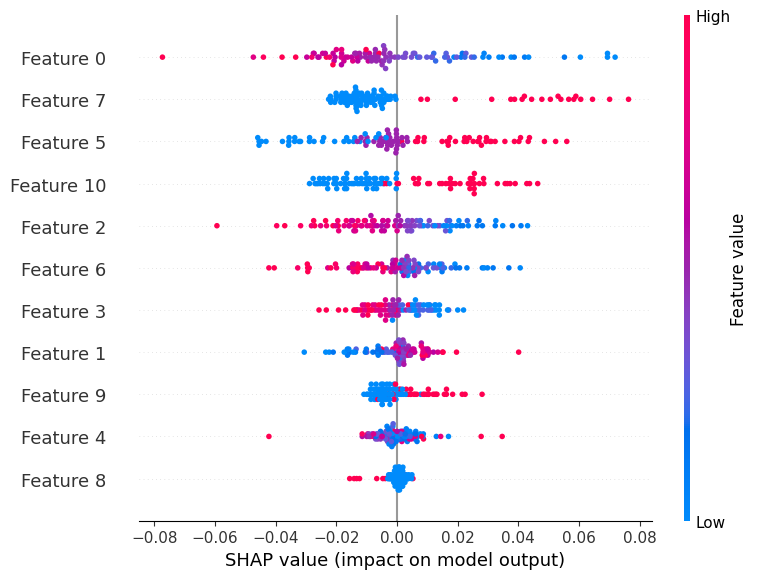

In [79]:
import shap

# Use the trained model 'model' instead of 'best_model'
explainer = shap.Explainer(model, X_test)
shap_values = explainer(X_test)

# Visualize feature importance
shap.summary_plot(shap_values, X_test)

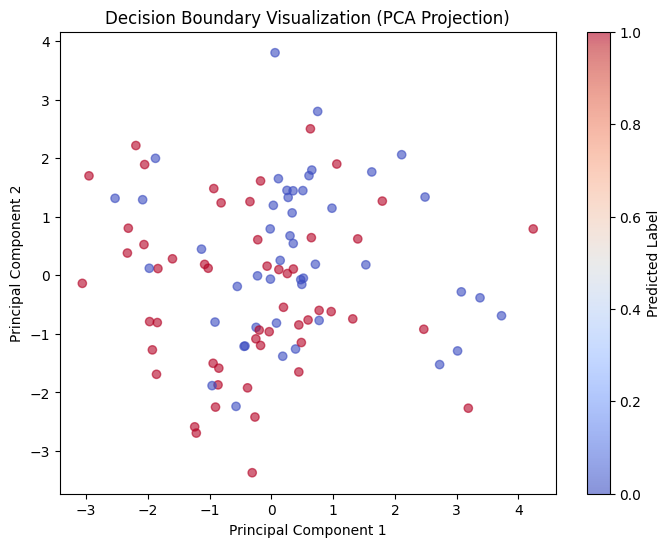

In [80]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# Reduce to 2D using PCA
pca = PCA(n_components=2)
X_test_pca = pca.fit_transform(X_test)

# Scatter plot
plt.figure(figsize=(8, 6))
plt.scatter(X_test_pca[:, 0], X_test_pca[:, 1], c=y_pred.flatten(), cmap="coolwarm", alpha=0.6)
plt.title("Decision Boundary Visualization (PCA Projection)")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.colorbar(label="Predicted Label")
plt.show()
